<a href="https://colab.research.google.com/github/qzlinqian/6_869_project_med_seg/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load data and basic setup

In [ ]:
use_gdrive = True  # want to use data in my google drive

In [ ]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/data"
else:
  data_dir = "./data"

datasets_dir = data_dir + '/Task03_Liver'

os.makedirs(datasets_dir, exist_ok=True)

training_imgs_dir = datasets_dir + '/imagesTr'
training_labels_dir = datasets_dir + '/labelsTr'
test_imgs_dir = datasets_dir + '/imagesTs'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import listdir
from os.path import isfile, join
# for f in listdir(training_imgs_dir):
  # print(f)
import nibabel as nib
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animate
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cv2 import imread, createCLAHE # read and equalize images
from glob import glob
import h5py
from IPython.display import HTML

In [ ]:
# for display the MRI images in animation
def create_gif(input_image, title='.gif', filename='test.gif'):
    # see example from matplotlib documentation
    images = []
    input_image_data = input_image.get_fdata().squeeze()
    fig = plt.figure()
    for i in range(input_image_data.shape[2]):
        im = plt.imshow(input_image_data[:,:,i], animated=True)
        images.append([im])
    ani = animate.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.close()
    return ani

img1 = nib.load(training_imgs_dir + "/liver_0.nii.gz")
ani = create_gif(img1, title='test', filename='test.gif')
HTML(ani.to_html5_video())

In [ ]:
img2 = nib.load(training_labels_dir + "/liver_0.nii.gz")
ani = create_gif(img2, title='test', filename='test.gif')
HTML(ani.to_html5_video())

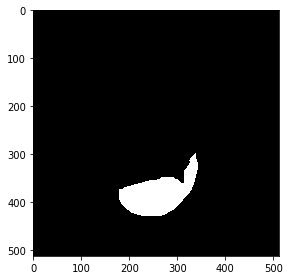

In [ ]:
img_arr = img2.get_fdata()
img_arr = np.squeeze(img_arr)
io.imshow(img_arr[:,:,50])

# 1. Initialize a new model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

In [ ]:
class ResUnet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter):
            x_init = x

            ## Conv 1
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)
            ## Conv 2
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            ## Conv 3
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)

            ## Shortcut
            s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
            s = BatchNormalization()(s)

            ## Add
            x = Add()([x, s])
            return x

        def resnet_block(x, n_filter, pool=True):
            x1 = conv_block(x, n_filter)
            c = x1

            ## Pooling
            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x2)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 96, 128]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = resnet_block(c0, n_filters[0])
        c2, p2 = resnet_block(p1, n_filters[1])
        c3, p3 = resnet_block(p2, n_filters[2])
        c4, p4 = resnet_block(p3, n_filters[3])

        ## Bridge
        b1 = resnet_block(p4, n_filters[4], pool=False)
        b2 = resnet_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = resnet_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = resnet_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = resnet_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = resnet_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model